In [1]:
# Uncomment below line and execute it Tensorflow is not installed

!pip install tensorflow

### Import Libraries

In [2]:
import pandas as pd
import numpy as np

from hdfs import InsecureClient
from sapdi import tracking

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import time


import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout ,Activation
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

np.random.seed(20)

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [3]:
client = InsecureClient('http://datalake:50070')
with client.read('/shared/ml/data/Power_Analysis/Household Power train data/household_power_consumption_hours.csv',
                 encoding = 'utf-8') as reader:
    
    df = pd.read_csv(reader,
                     index_col=[0],
                     date_parser= pd.to_datetime,
                     infer_datetime_format=True,
                     low_memory=False
                    )

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


### Split into Training and Test Sets

In [5]:
df_train = df.iloc[:-100]
df_test = df.iloc[-100:]

print('Training Set Shape : {}'.format(df_train.shape))
print('Testing Set Shape : {}'.format(df_test.shape))

Training Set Shape : (34489, 7)
Testing Set Shape : (100, 7)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34489 entries, 2006-12-16 17:00:00 to 2010-11-22 17:00:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34489 non-null  float64
 1   Global_reactive_power  34489 non-null  float64
 2   Voltage                34489 non-null  float64
 3   Global_intensity       34489 non-null  float64
 4   Sub_metering_1         34489 non-null  float64
 5   Sub_metering_2         34489 non-null  float64
 6   Sub_metering_3         34489 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2010-11-22 18:00:00 to 2010-11-26 21:00:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    100 non-null    float64
 1   Global_reactive_power  100 non-null    float64
 2   Voltage                100 non-null    float64
 3   Global_intensity       100 non-null    float64
 4   Sub_metering_1         100 non-null    float64
 5   Sub_metering_2         100 non-null    float64
 6   Sub_metering_3         100 non-null    float64
dtypes: float64(7)
memory usage: 6.2 KB


### Prepare the data for Training

In [8]:
look_back = 40

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = df_train.Global_active_power.values
train_data = train_data.reshape((-1,1))
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)

test_data = df_test.Global_active_power.values
test_data = test_data.reshape((-1,1))
test_data_scaled = scaler.transform(test_data)

In [10]:
def prepare_dataset(dataset, look_back=1):
    features, labels = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        features.append(a)
        labels.append(dataset[i + look_back, 0])
    return np.array(features), np.array(labels)

X_train, Y_train = prepare_dataset(train_data_scaled, look_back)
X_test, Y_test = prepare_dataset(test_data_scaled, look_back)

In [11]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [12]:
X_train.shape

(34448, 1, 40)

### Define the Model Architecture

In [13]:
def get_model():
    model = Sequential()
    model.add(LSTM(100,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(Dense(50))
    model.add(Dropout(rate=0.4))
    model.add(Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(optimizer= optimizer, loss='mse')
  
    return model

In [14]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 61,501
Trainable params: 61,501
Non-trainable params: 0
_________________________________________________________________


### Start Model Training

In [15]:
start = time.time()
run = tracking.start_run(run_collection_name='power_consumption_run')
try:
    history = model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split = 0.33, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

except KeyboardInterrupt:
    model.save('time_series_model.h5')
    print('Model Saved because of user input')   

print('\n LSTM Training Completed in {} seconds'.format(time.time()-start))

Train on 23080 samples, validate on 11368 samples
Epoch 1/30
23080/23080 [==============================] - 4s 165us/sample - loss: 0.0156 - val_loss: 0.0108
Epoch 2/30
23080/23080 [==============================] - 2s 107us/sample - loss: 0.0109 - val_loss: 0.0102
Epoch 3/30
23080/23080 [==============================] - 2s 105us/sample - loss: 0.0102 - val_loss: 0.0097
Epoch 4/30
23080/23080 [==============================] - 2s 104us/sample - loss: 0.0100 - val_loss: 0.0086
Epoch 5/30
23080/23080 [==============================] - 2s 103us/sample - loss: 0.0096 - val_loss: 0.0085
Epoch 6/30
23080/23080 [==============================] - 2s 101us/sample - loss: 0.0095 - val_loss: 0.0085
Epoch 7/30
23080/23080 [==============================] - 2s 104us/sample - loss: 0.0095 - val_loss: 0.0085
Epoch 8/30
23080/23080 [==============================] - 2s 104us/sample - loss: 0.0094 - val_loss: 0.0083
Epoch 9/30
23080/23080 [==============================] - 2s 103us/sample - loss: 0.00

In [16]:
tracking.log_parameters(parameters = {'n_epochs':history.params['epochs']})

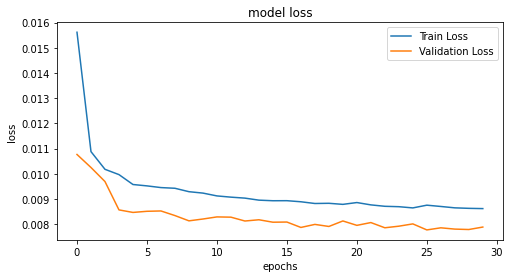

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [18]:
test_predict = model.predict(X_test)

In [19]:
test_predictions_scaled = scaler.inverse_transform(test_predict.reshape(-1,1))

In [20]:
from sklearn.metrics import mean_squared_error
lstm_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1,1)), test_predictions_scaled))

In [21]:
print('RMSE with LSTM Model is {}'.format(lstm_rmse))

RMSE with LSTM Model is 26.100054786838413


In [22]:
tracking.log_metric('RMSE' , lstm_rmse )
tracking.set_tags({
    "model" : "LSTM"
})

tracking.end_run()

### Now that we have saved our model let's make some future predictions and plot them

In [23]:
original_data = df.Global_active_power.values
original_data = original_data.reshape((-1,1))
scaler.fit(original_data)
original_data_scaled = scaler.transform(original_data)

In [24]:
def generate_lstm_forecasts(num_prediction, model):
    prediction_list = original_data_scaled[-look_back:]
    
    for _ in range(num_prediction):
        row_for_next_prediction = prediction_list[-look_back:]
        row_for_next_prediction = row_for_next_prediction.reshape((1, 1, look_back))
        prediction = model.predict(row_for_next_prediction)[0][0]
        prediction_list = np.append(prediction_list, prediction)
        
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def generate_future_timestamps(num_prediction):
    last_date = df.index[-1]
    prediction_dates = pd.date_range(last_date,freq='H', periods=num_prediction+1).tolist()
    return prediction_dates


In [25]:
num_prediction = 72
forecast = generate_lstm_forecasts(num_prediction, model)
forecast_dates = generate_future_timestamps(72)

In [26]:
df_forecast = pd.DataFrame()
df_forecast['datetime'] = forecast_dates
df_forecast['Forecast_LSTM'] = scaler.inverse_transform(forecast.reshape(-1,1))

In [27]:
df_forecast.set_index('datetime',inplace=True)
df_forecast.head()

,Forecast_LSTM
datetime,
2010-11-26 21:00:00,2.804000
2010-11-26 22:00:00,9.322278
2010-11-26 23:00:00,13.850532
2010-11-27 00:00:00,14.306139
2010-11-27 01:00:00,17.047348


In [28]:
df_forecast.head(35)

,Forecast_LSTM
datetime,
2010-11-26 21:00:00,2.804000
2010-11-26 22:00:00,9.322278
2010-11-26 23:00:00,13.850532
2010-11-27 00:00:00,14.306139
2010-11-27 01:00:00,17.047348
2010-11-27 02:00:00,16.421514
2010-11-27 03:00:00,21.195101
2010-11-27 04:00:00,24.938005
2010-11-27 05:00:00,34.424664


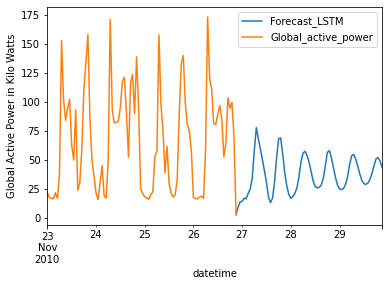

In [29]:
# Plot the forecast values from 26th November 2010 21:00:00 onwards
ax = df_forecast.plot()
ax = df.Global_active_power['11/23/2010':].plot()
ax.set_ylabel('Global Active Power in Kilo Watts')
ax.legend()
plt.show()

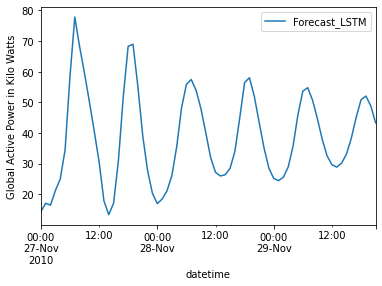

In [30]:
ax = df_forecast['11/27/2010': '11/29/2010'].plot()
ax.set_ylabel('Global Active Power in Kilo Watts')
ax.legend()
plt.show()

In [31]:
model.save('lstm_time_series_model_working.h5')

In [32]:
# save the model to disk
import pickle

filename = 'train_data_for_LSTM_modek.pkl'
pickle.dump(df, open(filename, 'wb'))

In [33]:
import sapdi
import json

In [34]:
sc = sapdi.get_current_scenario()

In [35]:
run_data =  tracking.get_runs( scenario = sc,notebook = sapdi.scenario.Notebook.get(notebook_id="30 Training LSTM Model.ipynb"))

In [36]:
run_json = json.loads(str(run_data))

In [37]:
df = pd.DataFrame.from_dict(run_json[0]['metrics'])

In [38]:
df.head()

,name,timestamp,value
0,RMSE,2020-04-02T17:45:13.533719Z,24.820589


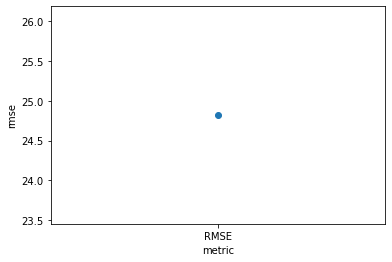

In [39]:
import matplotlib.pyplot as plt
plt.scatter(x = df.name , y = df.value )
plt.xlabel('metric')
plt.ylabel('rmse')
plt.show()